# Quora question pair similarity

## 1.0. Business Problem

### 1.0.1. Problem Description

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
>  Credits: Kaggle 

**__ Problem Statement __**
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

### 1.0.2. Useful Links

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

### 1.0.3. Business Objectives/ and Contstraints

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

## 2.0. Machine Learning Problem

### 2.0.1. Data

__Creating Kaggle json file__

In [2]:
# all imports

# imports for getting and uploading data google cloud
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# for creating  plots
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
from plotly import plotly
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# scipy imports
import pandas as pd
import numpy as np

#ignore warnings
import warnings
warnings.filterwarnings("ignore")



import os
import gc

#imports nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup # this is for scrapping
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
!pip install distance
import distance
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

#other imports
import time

from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

     |████████████████████████████████| 993kB 4.8MB/s 


     |████████████████████████████████| 184kB 4.9MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp36-none-any.whl size=16261 sha256=ca88951b2e73c6b99de7cd5cc9da2f1b179f8f58f363e2508ec837bb5cec0c08
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = os.path.expanduser("~/.kaggle/kaggle.json") # "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


__installing kaggle__

In [0]:
!pip install kaggle

In [0]:
# import to data from kaggle to google cloud if not already
if (not os.path.exists('./train.csv.zip')):
   !kaggle datasets download -d quora/question-pairs-dataset
else:
  print('files already exists')


404 - Not Found


In [0]:
#read train.csv from google drive if kaggle is returning 404


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
if (not os.path.exists('./train.csv.zip')):
  file_id = '10QDGTSI5PEV9e7CTpfzsXRpUwRIsJA-J'
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile('train.csv')
  # print('Downloaded content "{}"'.format(downloaded.GetContentString()))
else:
  print('file already exists')
 

In [0]:
#unzip all the zip files
if ((not os.path.exists('./sample_submission.csv')) and (not os.path.exists('./train.csv'))
 and (not os.path.exists('./test.csv'))):
  !unzip sample_submission.csv.zip
  !unzip train.csv.zip
  !unzip test.csv.zip
else:
  print('files already unzipped')

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
#read contents to df

df = pd.read_csv("train.csv")
df.head(5)

id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  What is the step by step guide to invest in sh...            0
1   1     3  ...  What would happen if the Indian government sto...            0
2   2     5  ...  How can Internet speed be increased by hacking...            0
3   3     7  ...  Find the remainder when [math]23^{24}[/math] i...            0
4   4     9  ...            Which fish would survive in salt water?            0

[5 rows x 6 columns]

In [0]:
# basic info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

In [0]:
# simple stats

df.describe()

id           qid1           qid2   is_duplicate
count  404290.000000  404290.000000  404290.000000  404290.000000
mean   202144.500000  217243.942418  220955.655337       0.369198
std    116708.614502  157751.700002  159903.182629       0.482588
min         0.000000       1.000000       2.000000       0.000000
25%    101072.250000   74437.500000   74727.000000       0.000000
50%    202144.500000  192182.000000  197052.000000       0.000000
75%    303216.750000  346573.500000  354692.500000       1.000000
max    404289.000000  537932.000000  537933.000000       1.000000

## 3.0. Exploratory Data Analysis

### 3.0.1. Stats: Distribution of data points among output points

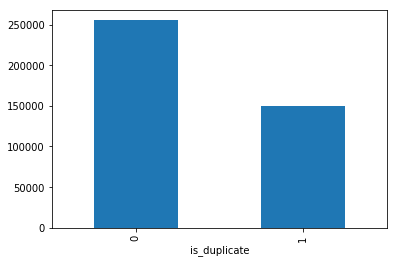

In [0]:

warnings.filterwarnings("ignore")

df.groupby("is_duplicate")['id'].count().plot.bar()

In [0]:
print("Total number of question pairs in train dataset: ", len(df))

Total number of question pairs in train dataset:  404290


In [0]:
print("Total number of question paies in train which are not duplicate: {}%".format(
    100 - round(df['is_duplicate'].mean()*100, 2)) )
print("Total number of duplicate question pairs {}%".format(round(df['is_duplicate'].mean()*100, 2)))

Total number of question paies in train which are not duplicate: 63.08%
Total number of duplicate question pairs 36.92%


### 3.0.2. Number of Unique Questions

In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

q_vals = qids.value_counts()

q_vals = q_vals.values

print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(q_vals))) 



Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



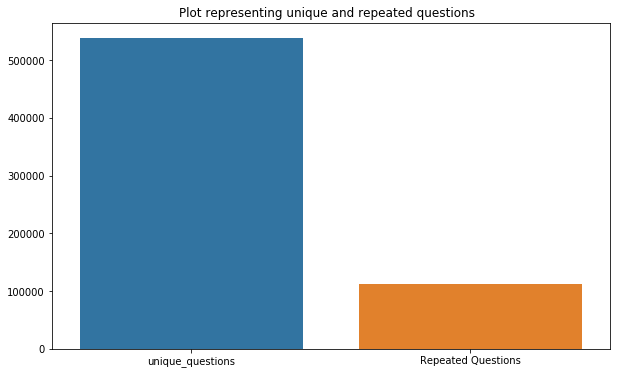

In [0]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

### 3.0.3. Checking for duplicate questions

In [0]:
#checking whether there are any repeated pair of questions

pairs_duplicate = df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()

print("number of duplicate question pairs: ", len(df) - len(pairs_duplicate))

number of duplicate question pairs:  0


### 3.0.4. Number of occurences of each question

Maximum number of times a single question is repeated: 157



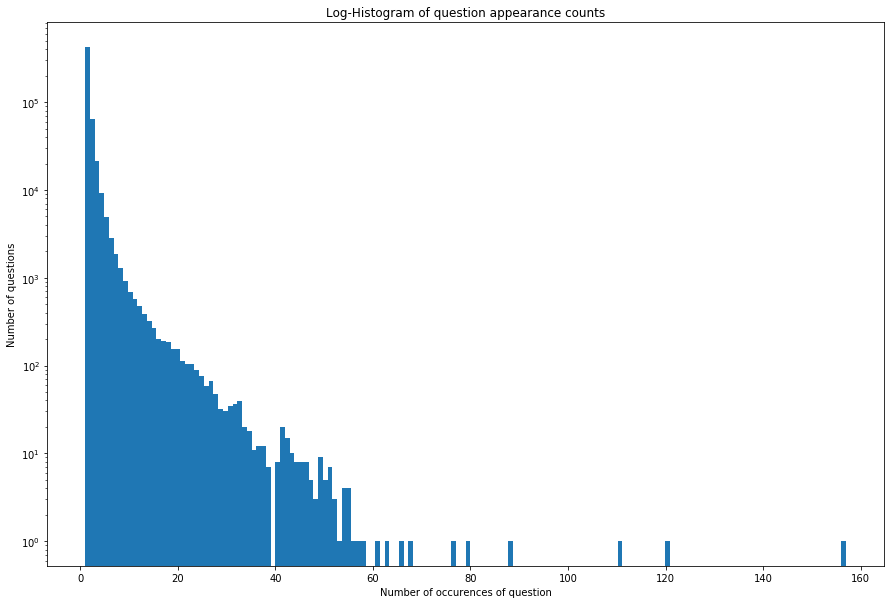

In [0]:
plt.figure(figsize=(15, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [0]:
# checking whether there are any null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


There are three rows with null values

---

In [0]:
# Filling the null values with ' '
df = df.fillna('null value')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## 4. Feature Extraction

### 4.1. Spliting the Data set

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(df, df['is_duplicate'], stratify=df['is_duplicate'], test_size=0.3)
print('training data set shape:', X_train.shape)
print('test data set shape', X_test.shape)

training data set shape: (283003, 6)
test data set shape (121287, 6)


### 4.1.1. Basic Feature Extraction

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 


__Create General Functions for Uploading and downloading from GDrive__

In [0]:
# upload file to google drive
def authenticateUser():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  return drive

def uploadFileToDrive(filename):
  drive = authenticateUser()
  # Create & upload a text file.
  uploaded = drive.CreateFile({'title': filename})
  uploaded.SetContentFile(filename)
  uploaded.Upload()
  print('Success! Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
# use this function to read files from Drive
def readFileFromDrive(file_name, file_id):
  drive = authenticateUser()
  if (not os.path.exists('./' + file_name)):
    file_id = file_id
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(file_name)
    # print('Downloaded content "{}"'.format(downloaded.GetContentString()))
  else:
    print('file already exists')

In [0]:
if os.path.isfile('X_fe_without_preprocessing_train.csv'):
    X_train = pd.read_csv("X_fe_without_preprocessing_train.csv",encoding='latin-1')
    X_test = pd.read_csv("X_fe_without_preprocessing_test.csv", encoding="latin-1")
else:
  # https://stackoverflow.com/a/22391554
  # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html
  X_train['freq_qid1'] = X_train.groupby('qid1')['qid1'].transform('count')
  X_train['freq_qid2'] = X_train.groupby('qid2')['qid2'].transform('count')
  X_test['freq_qid1'] = X_test.groupby('qid1')['qid1'].transform('count')
  X_test['freq_qid2'] = X_test.groupby('qid2')['qid2'].transform('count')

  X_train['q1len'] = [len(x.strip()) for x in X_train['question1']]
  X_train['q2len'] = [len(x.strip()) for x in X_train['question2']]
  X_test['q1len'] = [len(x.strip()) for x in X_test['question1']]
  X_test['q2len'] = [len(x.strip()) for x in X_test['question2']]

  X_train['q1_n_words'] = [len(x.strip().split(' ')) for x in X_train['question1']]
  X_train['q2_n_words'] = [len(x.strip().split(' ')) for x in X_train['question2']]
  X_test['q1_n_words'] = [len(x.strip().split(' ')) for x in X_test['question1']]
  X_test['q2_n_words'] = [len(x.strip().split(' ')) for x in X_test['question2']]

  w1 = [set(x.strip().lower().split(' ')) for x in X_train['question1']]
  w2 = [set(x.strip().lower().split(' ')) for x in X_train['question2']]
  X_train['word_Common'] = list(map(lambda x, y: len(x & y), w1, w2)) # set intersection operator
  w1 = [set(x.strip().lower().split(' ')) for x in X_test['question1']]
  w2 = [set(x.strip().lower().split(' ')) for x in X_test['question2']]
  X_test['word_Common'] = list(map(lambda x, y: len(x & y), w1, w2))

  w1 = [len(x.strip().split(' ')) for x in X_train['question1']]
  w2 = [len(x.strip().split(' ')) for x in X_train['question2']]
  X_train['word_Total'] = list(map(lambda x, y: x + y, w1, w2))
  w1 = [len(x.strip().split(' ')) for x in X_test['question1']]
  w2 = [len(x.strip().split(' ')) for x in X_test['question2']]
  X_test['word_Total'] = list(map(lambda x, y: x + y, w1, w2))

  X_train['word_share'] = list(map(lambda x, y: x / y if y != 0 else 0, X_train['word_Common'], X_train['word_Total']))
  X_test['word_share'] = list(map(lambda x, y: x / y if y != 0 else 0, X_test['word_Common'], X_test['word_Total']))

  X_train['freq_q1+freq_q2'] = list(map(lambda x,y: x + y, X_train['freq_qid1'], X_train['freq_qid2']))
  X_train['freq_q1-freq_q2'] = list(map(lambda x,y: abs(x - y), X_train['freq_qid1'], X_train['freq_qid2']))
  X_test['freq_q1+freq_q2'] = list(map(lambda x,y: x + y, X_test['freq_qid1'], X_test['freq_qid2']))
  X_test['freq_q1-freq_q2'] = list(map(lambda x,y: abs(x - y), X_test['freq_qid1'], X_test['freq_qid2']))

  X_train.to_csv("X_fe_without_preprocessing_train.csv", index=False)
  X_train.to_csv("X_fe_without_preprocessing_test.csv", index=False)

  uploadFileToDrive("X_fe_without_preprocessing_train.csv")
  uploadFileToDrive("X_fe_without_preprocessing_test.csv")

X_train.head(2)

Success! Uploaded file with ID 1khhoO9r1zs9loOoJEYcuFrLRQERv-S54
Success! Uploaded file with ID 1SiLZ7xEWko7bMbDqe4szidM4cpZ-o7kc


id    qid1    qid2  ... word_share freq_q1+freq_q2  freq_q1-freq_q2
36078    36078   65826   65827  ...   0.263158               2                0
367421  367421  497698  497699  ...   0.071429               2                0

[2 rows x 17 columns]

In [0]:
#reading files from google drive
#If above operation are already complete and files are saved to drive use readFileFromDrive function read data

### 4.2.1. Analysis of Extracted Features

#### 4.2.1.1. Questions with `one` word in train

In [0]:
print ("Minimum length of the questions in question1 : " , min(X_train['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(X_train['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", X_train[X_train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", X_train[X_train['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 51
Number of Questions with minimum length [question2] : 17


#### 4.2.1.2. Feature: word_share

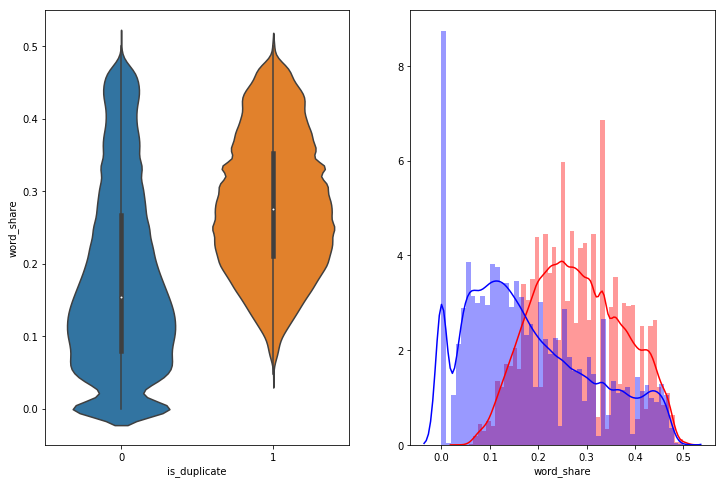

In [0]:
plt.figure(figsize=(12, 8))
plt.title('word share vs isduplicate')
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = X_train[0:])

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

#### 4.2.1.3. Feature: word_common

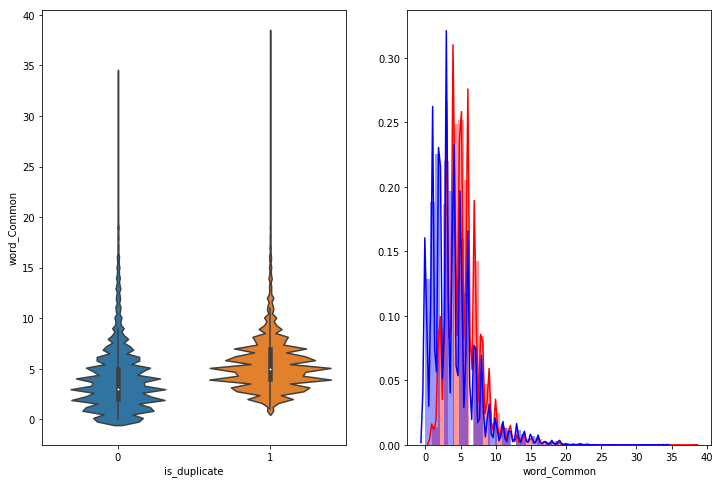

In [0]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = X_train[0:])

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

The distribution of similar and non similar features is higly overlapping

## 5.0. Preporcessing of Data

In [0]:
df.head(2)

id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  What is the step by step guide to invest in sh...            0
1   1     3  ...  What would happen if the Indian government sto...            0

[2 rows x 6 columns]

__Pre processing of text__

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [0]:
!pip install distance

In [0]:
!pip install fuzzywuzzy

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

### 5.1. Advanced Feature Extraction

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(X_train, X_test):
    # preprocessing each question
    X_train["question1"] = X_train["question1"].fillna("null values").apply(preprocess)
    X_train["question2"] = X_train["question2"].fillna("null values").apply(preprocess)
    X_test["question1"] = X_test["question1"].fillna("null values").apply(preprocess)
    X_test["question2"] = X_test["question2"].fillna("null values").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = X_train.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    token_features_test = X_test.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    X_train["cwc_min"]       = list(map(lambda x: x[0], token_features))
    X_train["cwc_max"]       = list(map(lambda x: x[1], token_features))
    X_train["csc_min"]       = list(map(lambda x: x[2], token_features))
    X_train["csc_max"]       = list(map(lambda x: x[3], token_features))
    X_train["ctc_min"]       = list(map(lambda x: x[4], token_features))
    X_train["ctc_max"]       = list(map(lambda x: x[5], token_features))
    X_train["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    X_train["first_word_eq"] = list(map(lambda x: x[7], token_features))
    X_train["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    X_train["mean_len"]      = list(map(lambda x: x[9], token_features))

    X_test["cwc_min"]       = list(map(lambda x: x[0], token_features_test))
    X_test["cwc_max"]       = list(map(lambda x: x[1], token_features_test))
    X_test["csc_min"]       = list(map(lambda x: x[2], token_features_test))
    X_test["csc_max"]       = list(map(lambda x: x[3], token_features_test))
    X_test["ctc_min"]       = list(map(lambda x: x[4], token_features_test))
    X_test["ctc_max"]       = list(map(lambda x: x[5], token_features_test))
    X_test["last_word_eq"]  = list(map(lambda x: x[6], token_features_test))
    X_test["first_word_eq"] = list(map(lambda x: x[7], token_features_test))
    X_test["abs_len_diff"]  = list(map(lambda x: x[8], token_features_test))
    X_test["mean_len"]      = list(map(lambda x: x[9], token_features_test))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    X_train["token_set_ratio"]       = X_train.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    X_train["token_sort_ratio"]      = X_train.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    X_train["fuzz_ratio"]            = X_train.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    X_train["fuzz_partial_ratio"]    = X_train.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    X_train["longest_substr_ratio"]  = X_train.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

    X_test["token_set_ratio"]       = X_test.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    X_test["token_sort_ratio"]      = X_test.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    X_test["fuzz_ratio"]            = X_test.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    X_test["fuzz_partial_ratio"]    = X_test.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    X_test["longest_substr_ratio"]  = X_test.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return X_train, X_test

In [0]:
""" files already exist in the google drive download them using readFilesFromDrive
function before proceeding to this step """

start_time = time.time()
if os.path.isfile('nlp_features_train.csv') and os.path.isfile('nlp_features_test.csv'):
    X_train = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    X_test = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    X_train.fillna('')
    X_test.fillna('')
else:
    print("Extracting features for train and test:")
    X_train, X_test = extract_features(X_train, X_test)
    X_train.to_csv("nlp_features_train.csv", index=False)
    X_test.to_csv("nlp_features_test.csv", index=False)
    
X_train.head(2)
X_test.head(2)
elapsed_time = time.time() - start_time
print('total time elapsed in the process: %H:%M:%S', time.gmtime(elapsed_time))

In [0]:
uploadFileToDrive("nlp_features_train.csv")
uploadFileToDrive("nlp_features_test.csv")

Success! Uploaded file with ID 1h3VgjON_hIWAVqP8W6-2jPy0Tjb6tqlN
Success! Uploaded file with ID 1bz8AdZNkLndY6ABHwlmYgjOtlTODyY5R


### 5.2. Analysis of Extracted features

####  5.2.1. Plotting word cloud

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [0]:
df_duplicate = X_train[X_train['is_duplicate'] == 1]
dfp_nonduplicate = X_train[X_train['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 208968
Number of data points in class 0 (non duplicate pairs) : 357038


In [0]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 11264054
Total number of words in non duplicate pair questions : 23244830


Word Cloud for Duplicate Question pairs


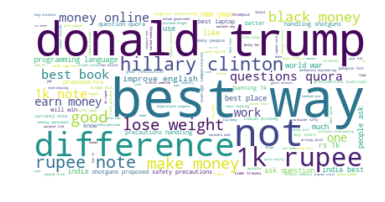

In [0]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


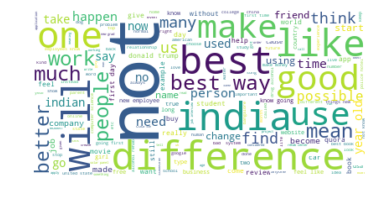

In [0]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 5.2.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

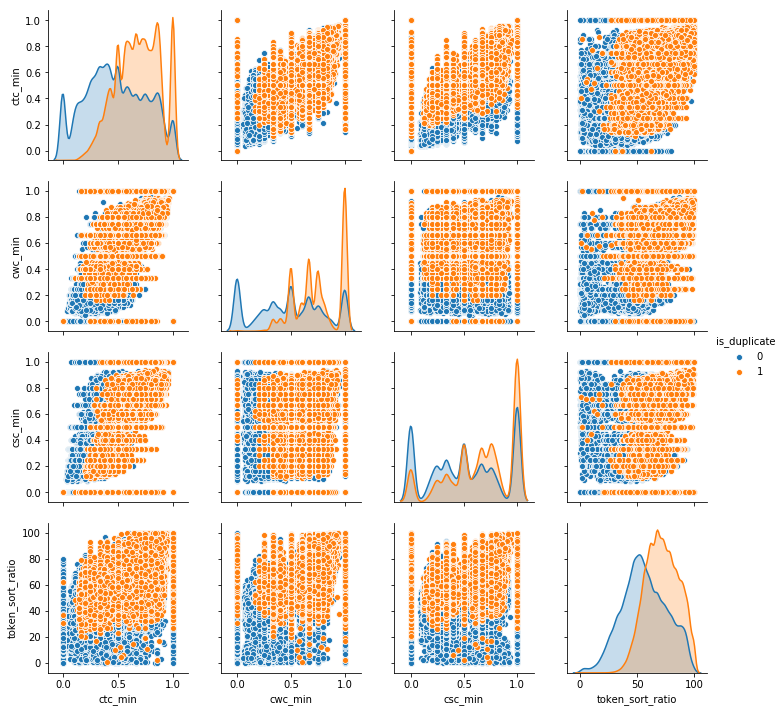

In [0]:
n = df.shape[0]
sns.pairplot(X_train[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

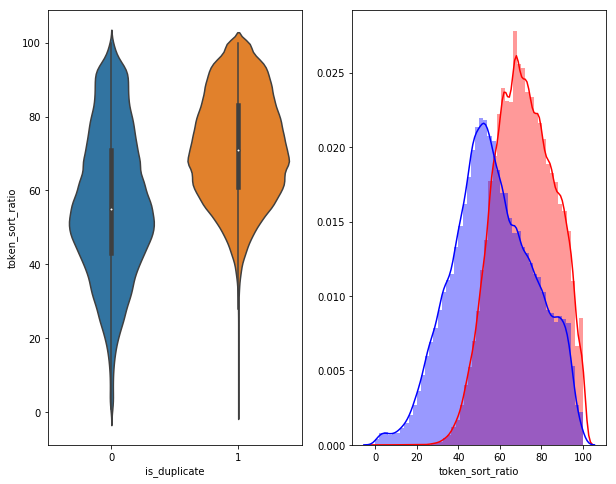

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = X_train[0:] , )

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

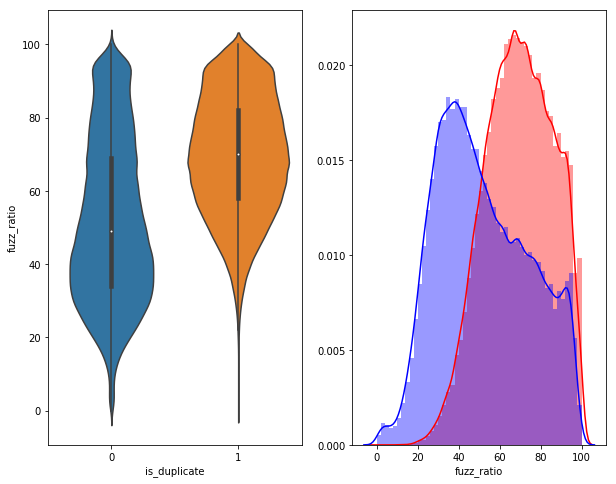

In [0]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = X_train[0:] , )

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

### 5.2.3. Visualization

In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = X_train[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [0]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.017s...
[t-SNE] Computed neighbors for 5000 samples in 0.406s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.132256
[t-SNE] Computed conditional probabilities in 0.289s
[t-SNE] Iteration 50: error = 82.6727982, gradient norm = 0.0382072 (50 iterations in 2.664s)
[t-SNE] Iteration 100: error = 70.6279449, gradient norm = 0.0099779 (50 iterations in 1.913s)
[t-SNE] Iteration 150: error = 68.8770905, gradient norm = 0.0054776 (50 iterations in 1.818s)
[t-SNE] Iteration 200: error = 68.1419830, gradient norm = 0.0042727 (50 iterations in 1.827s)
[t-SNE] Iteration 250: error = 67.7029724, gradient norm = 0.0039576

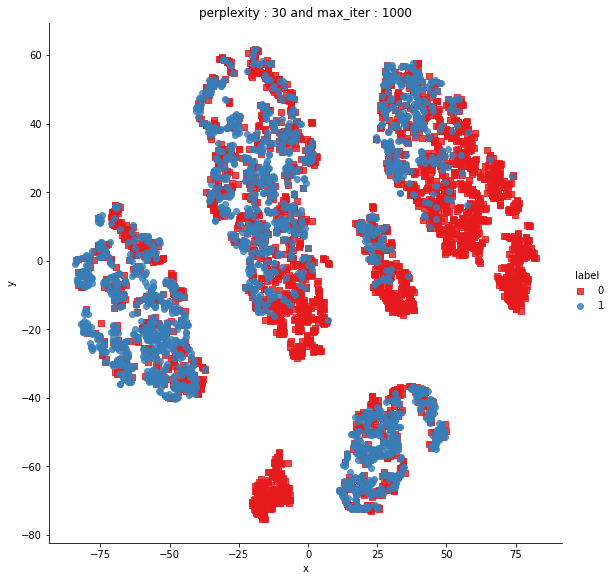

In [0]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [0]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 0.400s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.132256
[t-SNE] Computed conditional probabilities in 0.288s
[t-SNE] Iteration 50: error = 81.8635788, gradient norm = 0.0377580 (50 iterations in 10.862s)
[t-SNE] Iteration 100: error = 69.3089218, gradient norm = 0.0035522 (50 iterations in 5.591s)
[t-SNE] Iteration 150: error = 67.9657745, gradient norm = 0.0017443 (50 iterations in 4.901s)
[t-SNE] Iteration 200: error = 67.3951721, gradient norm = 0.0012273 (50 iterations in 5.046s)
[t-SNE] Iteration 250: error = 67.0557785, gradient norm = 0.000867

In [0]:
# enable plotly in the cell

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

In [0]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

enable_plotly_in_cell()
data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
iplot(fig, filename='3DBubble')

## 6.0. Featurizing text data with tfidf weighted word-vectors

In [0]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
import re
import time

In [0]:

# merge texts
questions = list(X_train['question1']) + list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False )
tfidf.fit(questions)
tfidf.transform(questions)
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [0]:
import sys
from time import sleep
from tqdm import tqdm
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
with tqdm(total=len(list(X_train['question1'])), file=sys.stdout) as pbar:
  i = 0
  for qu1 in list(X_train['question1']):
      doc1 = nlp(qu1)
      if (len(doc1) == 0):
        mean_vec1 = np.zeros(96)
      else:
        # 96 is the number of dimensions of vectors 
        mean_vec1 = np.zeros([len(doc1), 96])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch df score
            try:
                idf = word2tfidf[str(word1)]
            except:
                idf = 0
            # compute final vec
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
      vecs1.append(mean_vec1)

      i = i + 1
      pbar.set_description('processed: %d' % (1 + i))
      pbar.update(1)
X_train['q1_feats_m'] = list(vecs1)


processed: 283004: 100%|██████████| 283003/283003 [1:06:58<00:00, 70.42it/s]


In [0]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
with tqdm(total=len(list(X_train['question2'])), file=sys.stdout) as pbar:
  i = 0
  for qu1 in list(X_train['question2']):
      doc1 = nlp(qu1)
      if (len(doc1) == 0):
        mean_vec1 = np.zeros(96)
      else:
        # 384 is the number of dimensions of vectors 
        mean_vec1 = np.zeros([len(doc1), 96])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch df score
            try:
                idf = word2tfidf[str(word1)]
            except:
                idf = 0
            # compute final vec
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
      vecs1.append(mean_vec1)

      i = i + 1
      pbar.set_description('processed: %d' % (1 + i))
      pbar.update(1)
X_train['q2_feats_m'] = list(vecs1)


processed: 283004: 100%|██████████| 283003/283003 [1:07:07<00:00, 68.13it/s]


In [0]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
with tqdm(total=len(list(X_test['question1'])), file=sys.stdout) as pbar:
  i = 0
  for qu1 in list(X_test['question1']):
      doc1 = nlp(qu1)
      if (len(doc1) == 0):
        mean_vec1 = np.zeros(96)
      else:
        # 96 is the number of dimensions of vectors 
        mean_vec1 = np.zeros([len(doc1), 96])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch df score
            try:
                idf = word2tfidf[str(word1)]
            except:
                idf = 0
            # compute final vec
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
      vecs1.append(mean_vec1)

      i = i + 1
      pbar.set_description('processed: %d' % (1 + i))
      pbar.update(1)
X_test['q1_feats_m'] = list(vecs1)


processed: 121288: 100%|██████████| 121287/121287 [28:55<00:00, 69.89it/s]


In [0]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
with tqdm(total=len(list(X_test['question2'])), file=sys.stdout) as pbar:
  i = 0
  for qu1 in list(X_test['question2']):
      doc1 = nlp(qu1)
      if (len(doc1) == 0):
        mean_vec1 = np.zeros(96)
      else:
        # 384 is the number of dimensions of vectors 
        mean_vec1 = np.zeros([len(doc1), 96])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch df score
            try:
                idf = word2tfidf[str(word1)]
            except:
                idf = 0
            # compute final vec
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
      vecs1.append(mean_vec1)

      i = i + 1
      pbar.set_description('processed: %d' % (1 + i))
      pbar.update(1)
X_test['q2_feats_m'] = list(vecs1)


processed: 121288: 100%|██████████| 121287/121287 [28:55<00:00, 71.42it/s]


In [0]:
X_train.head(1)

id  ...                                         q2_feats_m
36078  36078  ...  [125.09504008293152, -55.89726996421814, -20.2...

[1 rows x 34 columns]

In [0]:
X_train = X_train.drop(['question1', 'question2'], axis=1)
X_test = X_test.drop(['question1', 'question2'],axis=1)
X_test.head(1)

id  ...                                         q2_feats_m
275418  275418  ...  [25.629388332366943, -0.23086118698120117, -32...

[1 rows x 32 columns]

In [0]:
df_train = X_train.drop(['qid1','qid2','is_duplicate', 'q1_feats_m', 'q2_feats_m'],axis=1)
df_test = X_test.drop(['qid1','qid2','is_duplicate', 'q1_feats_m', 'q2_feats_m'],axis=1)

In [0]:
df_q1_train = pd.DataFrame(X_train.q1_feats_m.values.tolist(), index= X_train.index)
df_q2_train = pd.DataFrame(X_train.q2_feats_m.values.tolist(), index= X_train.index)
df_q1_test = pd.DataFrame(X_test.q1_feats_m.values.tolist(), index= X_test.index)
df_q2_test = pd.DataFrame(X_test.q2_feats_m.values.tolist(), index= X_test.index)

In [0]:
df_q1_train.head(1)

0          1          2   ...       93        94        95
36078  101.492254 -23.689256 -39.024878  ... -30.2959 -0.959266 -5.383667

[1 rows x 96 columns]

In [0]:
# adding id to w2v rows
df_q1_train['id'] = X_train['id']
df_q2_train['id'] = X_train['id']
df_q1_test['id'] = X_test['id']
df_q2_test['id'] = X_test['id']

In [0]:
df_train  = df_train.merge(df_q1_train, on='id',how='left')
df_train  = df_train.merge(df_q2_train, on='id',how='left')
df_test  = df_test.merge(df_q1_test, on='id',how='left')
df_test  = df_test.merge(df_q2_test, on='id',how='left')


In [0]:
df_train.fillna(0)
df_test.fillna(0)
df_train.head(4)

id  freq_qid1  freq_qid2  ...       93_y        94_y       95_y
0   36078          1          1  ... -24.729291   -1.060976  11.735734
1  367421          1          1  ...  28.713746 -109.400765  38.394770
2  372910          5          9  ...   6.995593   -8.412396  22.779212
3  123791          1          1  ...  39.224820  -58.785566  58.387935

[4 rows x 219 columns]

In [0]:
if not os.path.isfile('final_features_train.csv') and not os.path.isfile('final_features_test.csv'):
  df_train.to_csv('final_features_train.csv')
  df_test.to_csv('final_features_test.csv')

__Upload Files To Drive For Reuse__

In [0]:
uploadFileToDrive('final_features_train.csv')
uploadFileToDrive('final_features_test.csv')

Success! Uploaded file with ID 13iGB_0CUHkkmmkK-7BSKjqNjhv1tGhEc
Success! Uploaded file with ID 1EqlcSctY0wrsW0Km1lRcrWaHUIwmrT1r


In [0]:
if not os.path.isfile('y_train.csv') and not os.path.isfile('y_test.csv'):
  y_train_df = pd.DataFrame({'id': y_train.index, 'is_duplicate': y_train.values})
  y_test_df = pd.DataFrame({'id': y_test.index, 'is_duplicate': y_test.values})
  y_train_df.to_csv('y_train.csv')
  y_test_df.to_csv('y_test.csv')
  uploadFileToDrive('y_train.csv')
  uploadFileToDrive('y_test.csv')
else:
  print('file already exists')

Success! Uploaded file with ID 1kGm9ar-gcvk1fT6F-_kqVMJPu6DybrEC
Success! Uploaded file with ID 1ohNuwxK4oH8xQZmBh-BMTiHIA7a_kjb4


__Read Files from Drive__

In [0]:
#download final_feature files from drive
readFileFromDrive('final_features_train.csv', '13iGB_0CUHkkmmkK-7BSKjqNjhv1tGhEc')
readFileFromDrive('final_features_test.csv', '1EqlcSctY0wrsW0Km1lRcrWaHUIwmrT1r')
readFileFromDrive('y_train.csv', '1kGm9ar-gcvk1fT6F-_kqVMJPu6DybrEC')
readFileFromDrive('y_test.csv', '1ohNuwxK4oH8xQZmBh-BMTiHIA7a_kjb4')

In [0]:
# freeup the ram
df_train = None
df_test = None
df_q1_train = None
df_q1_test = None
df_q2_train = None
df_q2_test = None
df = None
vecs1 = None

In [0]:
X_train = pd.read_csv('./final_features_train.csv')
X_test = pd.read_csv('./final_features_test.csv')
y_train = pd.read_csv('./y_train.csv')
y_test = pd.read_csv('./y_test.csv')

In [9]:
print('shape of X_train', X_train.shape)
print('shape of x_test', X_test.shape)
print('shape of y_train', y_train.shape)
print('shape of y_test', y_test.shape)

shape of X_train (283003, 220)
shape of x_test (121287, 220)
shape of y_train (283003, 3)
shape of y_test (121287, 3)


### 6.1. Featurizing Text data with TF-IDF word to vectors

In [0]:
# read data from npl_features_train and nlp_features_test from drive
readFileFromDrive('nlp_features_train.csv', '1h3VgjON_hIWAVqP8W6-2jPy0Tjb6tqlN')

In [0]:
readFileFromDrive('nlp_features_test.csv', '1bz8AdZNkLndY6ABHwlmYgjOtlTODyY5R')

In [0]:
x_train_normal = pd.read_csv('./nlp_features_train.csv')
x_test_normal = pd.read_csv('./nlp_features_test.csv')

In [0]:
x_train_normal.head(2)

id    qid1    qid2  ... fuzz_ratio fuzz_partial_ratio  longest_substr_ratio
0   36078   65826   65827  ...         49                 61              0.357143
1  367421  497698  497699  ...         38                 60              0.333333

[2 rows x 32 columns]

#### 6.1.1. TF-IDF vectorization of text data

In [0]:
x_train_normal =  x_train_normal.fillna(" ")
x_test_normal = x_test_normal.fillna(" ") 
x_train_normal.loc[x_train_normal['question1'].isnull()]

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+freq_q2, freq_q1-freq_q2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []

In [0]:


questions = list(x_train_normal['question1'])

tfidf = TfidfVectorizer(lowercase=False )
tfidf.fit(questions)
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
x_train_tfidf_q1 = tfidf.transform(x_train_normal['question1'][:70000])
x_test_tfidf_q1 = tfidf.transform(x_test_normal['question1'][:30000])

In [0]:

questions = list(x_train_normal['question2'])

tfidf = TfidfVectorizer(lowercase=False )
tfidf.fit(questions)
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
x_train_tfidf_q2 = tfidf.transform(x_train_normal['question2'][:70000])
x_test_tfidf_q2 = tfidf.transform(x_test_normal['question2'][:30000])

In [0]:
#list all the column names
print(x_train_normal.columns.values)
print(len(x_train_normal.columns.values))

['id' 'qid1' 'qid2' 'question1' 'question2' 'is_duplicate' 'freq_qid1'
 'freq_qid2' 'q1len' 'q2len' 'q1_n_words' 'q2_n_words' 'word_Common'
 'word_Total' 'word_share' 'freq_q1+freq_q2' 'freq_q1-freq_q2' 'cwc_min'
 'cwc_max' 'csc_min' 'csc_max' 'ctc_min' 'ctc_max' 'last_word_eq'
 'first_word_eq' 'abs_len_diff' 'mean_len' 'token_set_ratio'
 'token_sort_ratio' 'fuzz_ratio' 'fuzz_partial_ratio'
 'longest_substr_ratio']
32


In [0]:
from scipy.sparse import hstack

x_train_final_basic = np.concatenate(
    (np.array(list(x_train_normal['freq_qid1']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['freq_qid2']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['q1len']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['q2len']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['q1_n_words']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['q2_n_words']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['word_Common']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['word_Total']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['word_share']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['freq_q1+freq_q2']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['freq_q1-freq_q2']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['cwc_min']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['first_word_eq']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['abs_len_diff']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['mean_len']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['token_set_ratio']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['token_sort_ratio']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['fuzz_ratio']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['fuzz_partial_ratio']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['longest_substr_ratio']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['cwc_max']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['csc_min']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['csc_max']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['ctc_min']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['ctc_max']))[:70000].reshape(70000,1),
    np.array(list(x_train_normal['last_word_eq']))[:70000].reshape(70000,1)), axis=1
    )

In [0]:
x_test_final_basic = np.concatenate(
    (np.array(list(x_test_normal['freq_qid1']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['freq_qid2']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['q1len']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['q2len']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['q1_n_words']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['q2_n_words']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['word_Common']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['word_Total']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['word_share']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['freq_q1+freq_q2']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['freq_q1-freq_q2']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['cwc_min']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['first_word_eq']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['abs_len_diff']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['mean_len']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['token_set_ratio']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['token_sort_ratio']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['fuzz_ratio']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['fuzz_partial_ratio']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['longest_substr_ratio']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['cwc_max']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['csc_min']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['csc_max']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['ctc_min']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['ctc_max']))[:30000].reshape(30000,1),
    np.array(list(x_test_normal['last_word_eq']))[:30000].reshape(30000,1)), axis=1
    )

In [0]:
#hstack text features with numerical features
x_train_final = hstack((x_train_final_basic, x_train_tfidf_q1.tocsr(), x_train_tfidf_q2.tocsr()))
x_test_final = hstack((x_test_final_basic, x_test_tfidf_q1.tocsr(), x_test_tfidf_q2.tocsr()))

print(x_train_final.shape)
print(x_test_final.shape)

(70000, 112312)
(30000, 112312)


In [0]:
y_train = list(x_train_normal['is_duplicate'])[:70000]
y_test = list(x_test_normal['is_duplicate'])[:30000]

## 7.0. Buiding Models

### 7.1. Confusion matrix function

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [0]:
#run this data is based weighted word to vectors

y_train = y_train['is_duplicate']
y_test = y_test['is_duplicate']


In [0]:
#run this data is based weighted word to vectors
X_train = X_train[:70000]
X_test = X_test[:30000]
y_train = y_train[:70000]
y_test = y_test[:30000]

In [0]:
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix

### 7.2. Building Random Model

Log loss on Test Data using Random Model 0.8901246257459166


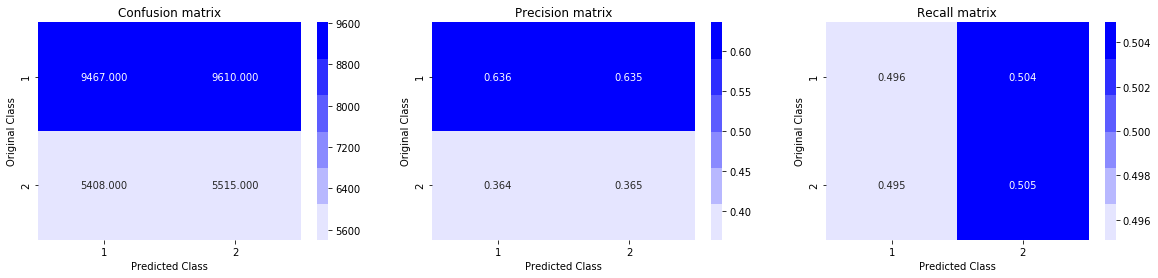

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

# Return predicted values based on the max value indices
predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### 7.3. Logistic Regression with Hyperparam tuning `tf idf vectors`

For values of alpha =  1e-05 The log loss is: 0.4534055363975184
For values of alpha =  0.0001 The log loss is: 0.4446041206460537
For values of alpha =  0.001 The log loss is: 0.4631761371004517
For values of alpha =  0.01 The log loss is: 0.49924116630138815
For values of alpha =  0.1 The log loss is: 0.5156480445455877
For values of alpha =  1 The log loss is: 0.5449335454990252
For values of alpha =  10 The log loss is: 0.5768064693652827


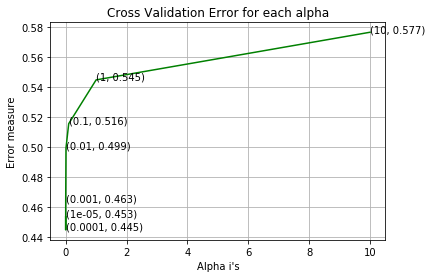

For values of best alpha =  0.0001 The train log loss is: 0.41256524731599226
For values of best alpha =  0.0001 The test log loss is: 0.4446041206460537
Total number of data points : 30000


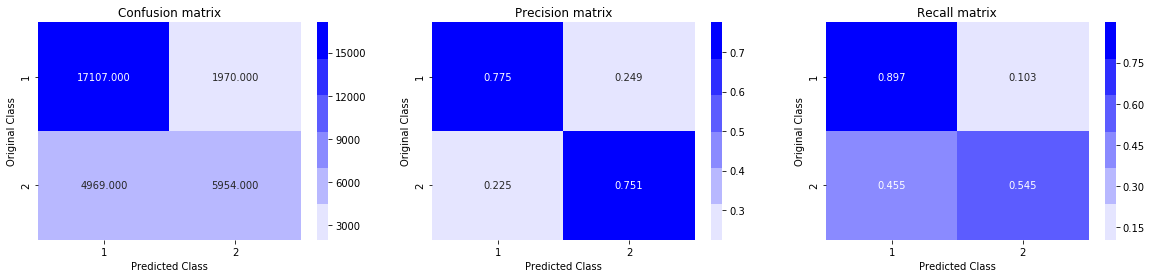

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train_final, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_final, y_train)
    predict_y = sig_clf.predict_proba(x_test_final)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",
          log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train_final, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_final, y_train)

predict_y = sig_clf.predict_proba(x_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)



*   The Log loss on the test data is aroudn 0.44 



### 7.4. Linear SVM with Hyper param tuning `tf-idf` vectors

For values of alpha =  1e-05 The log loss is: 0.468434472182571
For values of alpha =  0.0001 The log loss is: 0.4884108087629494
For values of alpha =  0.001 The log loss is: 0.5314522438011493
For values of alpha =  0.01 The log loss is: 0.5596905530360395
For values of alpha =  0.1 The log loss is: 0.5305975255470909
For values of alpha =  1 The log loss is: 0.6053092426323787
For values of alpha =  10 The log loss is: 0.601039030324734


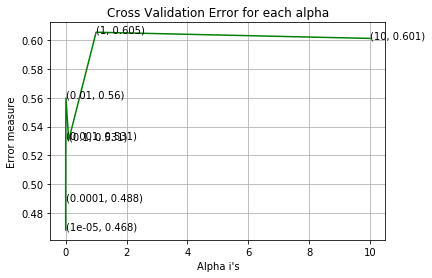

For values of best alpha =  1e-05 The train log loss is: 0.43776585631072856
For values of best alpha =  1e-05 The test log loss is: 0.468434472182571
Total number of data points : 30000


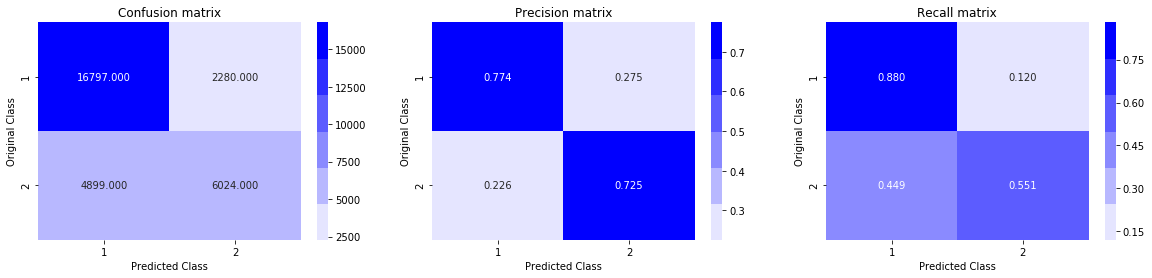

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(x_train_final, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_final, y_train)
    predict_y = sig_clf.predict_proba(x_test_final)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train_final, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_final, y_train)

predict_y = sig_clf.predict_proba(x_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### 7. 5. Logistic regression with `tf-idf weighted word to vectors`

For values of alpha =  1e-05 The log loss is: 0.6559030190262478
For values of alpha =  0.0001 The log loss is: 0.6559030190262478
For values of alpha =  0.001 The log loss is: 0.6559030190262478
For values of alpha =  0.01 The log loss is: 0.6559030190262478
For values of alpha =  0.1 The log loss is: 0.6362241412604637
For values of alpha =  1 The log loss is: 0.6468304648893773
For values of alpha =  10 The log loss is: 0.6086987023912096


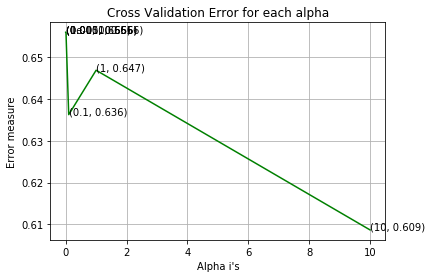

For values of best alpha =  10 The train log loss is: 0.6108221354693663
For values of best alpha =  10 The test log loss is: 0.6086987023912096
Total number of data points : 30000


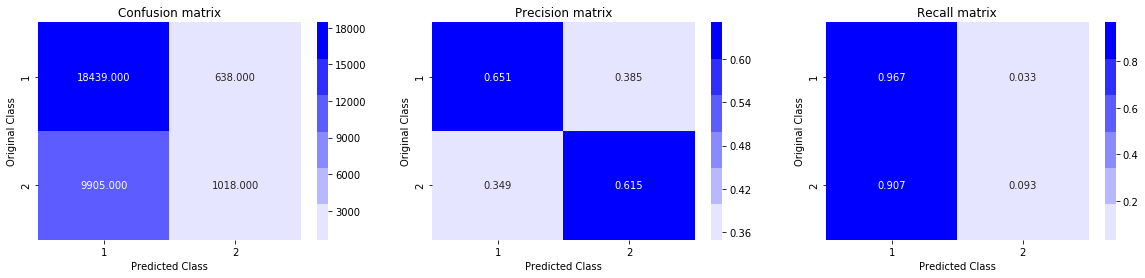

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train.iloc[:70000], y_train['is_duplicate'][:70000])
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train.iloc[:70000], y_train['is_duplicate'][:70000])
    predict_y = sig_clf.predict_proba(X_test.iloc[:30000])
    log_error_array.append(log_loss(y_test['is_duplicate'][:30000], predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test['is_duplicate'][:30000], predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train.iloc[:70000], y_train['is_duplicate'][:70000])
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train.iloc[:70000], y_train['is_duplicate'][:70000])

predict_y = sig_clf.predict_proba(X_train.iloc[:70000])
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train['is_duplicate'][:70000], predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test.iloc[:30000])
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test['is_duplicate'][:30000], predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test['is_duplicate'][:30000], predicted_y)

### 7.6. SVM with `tf-idf weighted word to vectors`

For values of alpha =  1e-05 The log loss is: 0.6559030190262478
For values of alpha =  0.0001 The log loss is: 0.6559030190262478
For values of alpha =  0.001 The log loss is: 0.6559030190262478
For values of alpha =  0.01 The log loss is: 0.6559030190262478
For values of alpha =  0.1 The log loss is: 0.6559030190262478
For values of alpha =  1 The log loss is: 0.6559030190262478
For values of alpha =  10 The log loss is: 0.6559030190262478


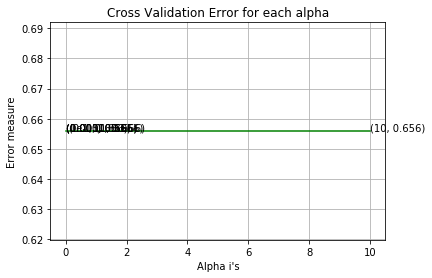

For values of best alpha =  1e-05 The train log loss is: 0.6604216563856597
For values of best alpha =  1e-05 The test log loss is: 0.6559030190262478
Total number of data points : 30000


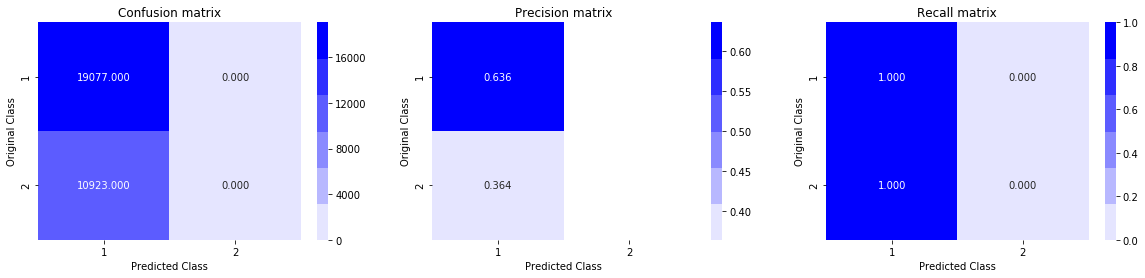

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train.iloc[:70000], y_train['is_duplicate'][:70000])
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train.iloc[:70000], y_train['is_duplicate'][:70000])
    predict_y = sig_clf.predict_proba(X_test.iloc[:30000])
    log_error_array.append(log_loss(y_test['is_duplicate'][:30000], predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test['is_duplicate'][:30000], predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train.iloc[:70000], y_train['is_duplicate'][:70000])
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train.iloc[:70000], y_train['is_duplicate'][:70000])

predict_y = sig_clf.predict_proba(X_train.iloc[:70000])
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train['is_duplicate'][:70000], predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test.iloc[:30000])
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test['is_duplicate'][:30000], predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test['is_duplicate'][:30000], predicted_y)

### 7.7. XGBoost

In [3]:
!sudo pip3 install xgboost
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [0]:

def applyRandomSearchCV():
  
  max_depth = [1,3,5]
  n_estimators = [5,10,100,200,400]

  bst = xgb.XGBClassifier()

  tuned_parameters = {'max_depth': max_depth, 'n_estimators': n_estimators}
  clf = RandomizedSearchCV(bst, tuned_parameters, scoring = 'neg_log_loss', cv=3,verbose=5, return_train_score=True)
  clf.fit(X_train.iloc[:70000], y_train[:70000])

  return clf.best_params_
  

In [38]:
best_params = applyRandomSearchCV()
print(best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=10, max_depth=3 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=10, max_depth=3, score=(train=-0.496, test=-0.496), total=   8.1s
[CV] n_estimators=10, max_depth=3 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV]  n_estimators=10, max_depth=3, score=(train=-0.496, test=-0.497), total=   8.2s
[CV] n_estimators=10, max_depth=3 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.7s remaining:    0.0s


[CV]  n_estimators=10, max_depth=3, score=(train=-0.496, test=-0.498), total=   8.1s
[CV] n_estimators=10, max_depth=5 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.0s remaining:    0.0s


[CV]  n_estimators=10, max_depth=5, score=(train=-0.470, test=-0.473), total=  12.7s
[CV] n_estimators=10, max_depth=5 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   37.9s remaining:    0.0s


[CV]  n_estimators=10, max_depth=5, score=(train=-0.468, test=-0.472), total=  12.8s
[CV] n_estimators=10, max_depth=5 ....................................
[CV]  n_estimators=10, max_depth=5, score=(train=-0.469, test=-0.472), total=  12.7s
[CV] n_estimators=200, max_depth=3 ...................................
[CV]  n_estimators=200, max_depth=3, score=(train=-0.342, test=-0.362), total= 2.3min
[CV] n_estimators=200, max_depth=3 ...................................
[CV]  n_estimators=200, max_depth=3, score=(train=-0.341, test=-0.363), total= 2.3min
[CV] n_estimators=200, max_depth=3 ...................................
[CV]  n_estimators=200, max_depth=3, score=(train=-0.342, test=-0.397), total= 2.3min
[CV] n_estimators=10, max_depth=1 ....................................
[CV]  n_estimators=10, max_depth=1, score=(train=-0.561, test=-0.560), total=   3.6s
[CV] n_estimators=10, max_depth=1 ....................................
[CV]  n_estimators=10, max_depth=1, score=(train=-0.560, test

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 32.0min finished


{'n_estimators': 100, 'max_depth': 5}


In [0]:
from sklearn.metrics import SCORERS

sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [46]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 5

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))

[0]	train-logloss:0.68443	valid-logloss:0.685367
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.614597	valid-logloss:0.620707
[20]	train-logloss:0.562847	valid-logloss:0.573389
[30]	train-logloss:0.523193	valid-logloss:0.537733
[40]	train-logloss:0.493094	valid-logloss:0.51075
[50]	train-logloss:0.46956	valid-logloss:0.489831
[60]	train-logloss:0.451096	valid-logloss:0.473562
[70]	train-logloss:0.436374	valid-logloss:0.46055
[80]	train-logloss:0.42427	valid-logloss:0.449865
[90]	train-logloss:0.414541	valid-logloss:0.441363
[100]	train-logloss:0.406543	valid-logloss:0.434628
[110]	train-logloss:0.399982	valid-logloss:0.428961
[120]	train-logloss:0.394438	valid-logloss:0.424256
[130]	train-logloss:0.389728	valid-logloss:0.42045
[140]	train-logloss:0.385788	valid-logloss:0.417169
[150]	train-logloss:0.382429	valid-logloss:0.414438
[160]	train-logloss:0.37931	valid-

Total number of data points : 30000


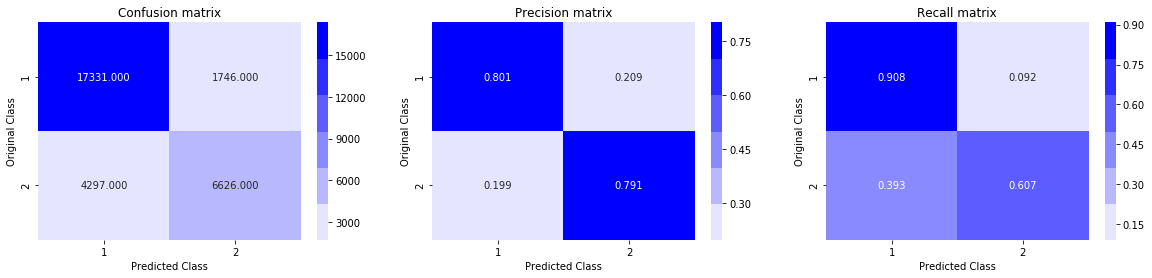

In [47]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Conclusions

In [50]:
# Compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

#AUC: area under curve for Test data

x = PrettyTable()
x.field_names = ["Model","loss fn","Test log loss"]

x.add_row(['Random model', 'log loss', 0.89])
x.add_row(['LR: weighted tf-idf', 'log loss', 0.608])
x.add_row(['SVM: weighted tf-idf', 'log loss', 0.655])
x.add_row(['LR: normal tf-idf', 'log loss', 0.444])
x.add_row(['svm: normal tf-idf', 'log loss', 0.463])
x.add_row(['XG:boost: weighted tf-idf with hyper param tuning', 'log loss', 0.384])

print(x)

+---------------------------------------------------+----------+---------------+
|                       Model                       | loss fn  | Test log loss |
+---------------------------------------------------+----------+---------------+
|                    Random model                   | log loss |      0.89     |
|                LR: weighted tf-idf                | log loss |     0.608     |
|                SVM: weighted tf-idf               | log loss |     0.655     |
|                 LR: normal tf-idf                 | log loss |     0.444     |
|                 svm: normal tf-idf                | log loss |     0.463     |
| XG:boost: weighted tf-idf with hyper param tuning | log loss |     0.384     |
+---------------------------------------------------+----------+---------------+
